In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from matplotlib import colors
import xml.etree.cElementTree as ET
import glob, os
from operator import itemgetter
from itertools import groupby

%matplotlib inline

# FUNCTION: READ MSDB

In [2]:
def search_MSDB(msdbfile, section, seg, act):
    MSDBtree = ET.ElementTree(file=msdbfile)
    
    root = MSDBtree.getroot()

    for elem in MSDBtree.iterfind(section.upper()+'/SEGMENT[@id="{:d}"]'.format(seg)):
        #print elem.tag, elem.attrib   
        piston = (float( elem.find('PISTON').text) )
        for node in elem.iterfind('ACTUATOR[@id="{:d}"]'.format(act)):
            #print node.tag, node.attrib
            LVDT = (int( node.find('LVDT').text) )
            CSC  = int( node.find('CSC').text)

            
    return LVDT, piston, CSC

# FUNCTION: PARSE WFC RECORD FILE

In [3]:
def search_record(recordfile, track_lvdt):

    Recordt_tree = ET.ElementTree(file=recordfile)
    #root = Recordt_tree.getroot()

    record = []

    for elem in Recordt_tree.iterfind('GROUP/RECORD'):
        #print elem.tag, elem.attrib 

        alllvdt = []
        for node in elem.findall("COMMAND/LVDT/COL/"):
            #print node.tag, node.text
            alllvdt.append(int(node.text))
         
        for node in elem.iterfind('RESPONSE'):
            bipod = np.nan
            #print node.tag, node.attrib
            CID         = node.find('CORRECTION_ID').text
            CMD_NUM     = int( node.find('CMD_NUM').text) 
            SEG_ID      = int( node.find('SEG_ID').text) 
            ACT_ID      = int( node.find('ACT_ID').text) 
            END_LVDT_ADU   = int( node.find('END_LVDT').text)
            START_LVDT_ADU = int( node.find('START_LVDT').text)
            START_LVDT_MCS = alllvdt[ACT_ID-1]
                   
            END_LVDT_MCS, piston, CSC = search_MSDB(msdbfile, "PREDICTED", SEG_ID, ACT_ID)
            
            track_lvdt[SEG_ID-1, ACT_ID-1] = START_LVDT_ADU
            
            try:
                bipod = np.nan
                if ACT_ID==2: bipod = START_LVDT_ADU - track_lvdt[SEG_ID-1, ACT_ID-2]
                if ACT_ID==4: bipod = START_LVDT_ADU - track_lvdt[SEG_ID-1, ACT_ID-2]
                if ACT_ID==6: bipod = START_LVDT_ADU - track_lvdt[SEG_ID-1, ACT_ID-2]
                    
                record.append( [SEG_ID, ACT_ID, START_LVDT_ADU, START_LVDT_MCS, END_LVDT_ADU, 
                                END_LVDT_MCS, CID, CMD_NUM, piston, bipod] )
                
                writer.writerow( ([CMD_NUM, CID, SEG_ID, ACT_ID, START_LVDT_ADU, START_LVDT_MCS, END_LVDT_ADU, 
                                   END_LVDT_MCS, piston, bipod]) )
            except: 
                record.append( [SEG_ID, ACT_ID, START_LVDT_ADU, START_LVDT_MCS, END_LVDT_ADU, 
                                END_LVDT_MCS, CID, CMD_NUM, piston] )
            
                writer.writerow( ([CMD_NUM, CID, SEG_ID, ACT_ID, START_LVDT_ADU, START_LVDT_MCS, END_LVDT_ADU, 
                                   END_LVDT_MCS, piston]) )
            
            

    return record, track_lvdt

# MAIN: LOOP ARCHIVE PACKAGES

In [4]:
tolerance_mode = "MCS"

segmentnames = ["A1-1", "A2-2", "A3-3", "A4-4", "A5-5", "A6-6",
                "B1-7", "C1-8", "B2-9", "C2-10","B3-11", "C3-12", 
                "B4-13", "C4-14", "B5-15","C5-16", "B6-17", "C6-18", "SM-19"]

# LIST IN ORDER:

# homedir = "/Users/lajoie/SSDIF_OTIS_SFT/PRE-VIBE-DEPLOYMENT/"
# ArchivePackages = [
#                     "X201610190B-OPS-clajoie-MCS-CONFIRM-02",
#                     "M201610190C-OPS-clajoie-MCS-CONFIRM-02",
#                     "E201610190D-OPS-tcomeau-MCS-CONFIRM-02",
#                     "E201610190E-OPS-tcomeau-MCS-CONFIRM-02",
#                     "E201610190F-OPS-tcomeau-MCS-CONFIRM-02",
#                     "E201610190G-OPS-tcomeau-MCS-CONFIRM-02",
#                     "E201610190H-OPS-tcomeau-MCS-CONFIRM-02",
#                     "E201610190I-OPS-tcomeau-MCS-CONFIRM-02",
#                     "M201610190O-OPS-clajoie-MCS-CONFIRM-02",
#                     "M201610190P-OPS-clajoie-MCS-CONFIRM-02",
#                     "M2016102001-OPS-clajoie-MCS-CONFIRM-02",
#                     "M2016102002-OPS-clajoie-MCS-CONFIRM-02",
#                     "M2016102003-OPS-clajoie-MCS-CONFIRM-02",
#                     "M2016102004-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102101-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102204-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102301-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102302-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102303-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102304-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102305-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102306-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M2016102307-OPS-jrtersig-MCS-CONFIRM-02",
#                     "M201610230A-OPS-clajoie-MCS-CONFIRM-02",
#                     "M201610230B-OPS-clajoie-MCS-CONFIRM-02",
#                     "M201610230C-OPS-clajoie-MCS-CONFIRM-02",
#                     "M201610230D-OPS-clajoie-MCS-CONFIRM-02",
#                     "M201610230E-OPS-clajoie-MCS-CONFIRM-02",
#                     "M201610230F-OPS-clajoie-MCS-CONFIRM-02",
#                     "E2016110402-OPS-jrtersig-MCS-CONFIRM-02",
#                     "E2016110403-OPS-jrtersig-MCS-CONFIRM-02",
#                     "E2016110405-OPS-tchonis-MCS-CONFIRM-02",
#                     "E2016110408-OPS-tchonis-MCS-CONFIRM-02",
#                     "E2016110502-OPS-eccoppoc-MCS-CONFIRM-02"
#                    ]    



# homedir = "/Users/lajoie/SSDIF_OTIS_SFT/POST-VIBE-DEPLOYMENT/"
# ArchivePackages = [
#                     "E201703210H-OPS-wssotis1-MCS-CONFIRM-02", 
#                     "X2017032205-OPS-wssotis1-MCS-CONFIRM-02",
#                     "E201703220D-OPS-wssotis1-MCS-CONFIRM-02",
#                     "X201703220G-OPS-wssotis1-MCS-CONFIRM-04",
#                     "M2017032305-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032306-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032401-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032402-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032403-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032404-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032405-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032406-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032407-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032408-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032409-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M201703240A-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032502-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032503-OPS-wssotis1-MCS-CONFIRM-02",
#                     "M2017032504-OPS-wssotis1-MCS-CONFIRM-02"
    
# ]



homedir = "/Users/lajoie/JSC_OTIS_SFT/"
ArchivePackages = [ 
                    "E2016051107-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2016050904-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2017071602-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2017071603-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2017071604-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2017071605-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2017071701-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2017071702-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2017071703-OPS-wssotis1-MCS-CONFIRM-02",
                    "M2017071704-OPS-wssotis1-MCS-CONFIRM-02",
                    "N2017071803-OPS-wssotis1-MCS-CONFIRM-02",
                    "N2017071804-OPS-wssotis1-MCS-CONFIRM-02",
                    "N2017071805-OPS-wssotis1-MCS-CONFIRM-02",
                    "N2017071901-OPS-wssotis1-MCS-CONFIRM-02"
                   ]

narch = len(ArchivePackages)

outputcsv = 'LVDT_table.csv'
f = open(outputcsv, 'wt')
writer = csv.writer(f)
writer.writerow( ("CMD_NUM", "CID", "SEG_ID", "ACT_ID", "START_LVDT_ADU", 
                  "START_LVDT_MCS", "END_LVDT_ADU","END_LVDT_MCS","PISTON","BIPOD_DIFF") )
print homedir


records = []
linecounter = 1
track_lvdt = np.empty( (19,6) )
for iarch in ArchivePackages:
    print iarch
    
    APdir      = homedir+iarch
    msdbfile   = APdir+"/JWST_FLIGHT_MSDB.xml"
    recordfile = APdir+'/wavefront_control_record.xml'

    temp, track_lvdt = search_record(recordfile, track_lvdt)
    records.append( temp )


# CONCATENATE INTO A SINGLE LIST:
records = sum(records, [])

/Users/lajoie/JSC_OTIS_SFT/
E2016051107-OPS-wssotis1-MCS-CONFIRM-02
M2016050904-OPS-wssotis1-MCS-CONFIRM-02
M2017071602-OPS-wssotis1-MCS-CONFIRM-02
M2017071603-OPS-wssotis1-MCS-CONFIRM-02
M2017071604-OPS-wssotis1-MCS-CONFIRM-02
M2017071605-OPS-wssotis1-MCS-CONFIRM-02
M2017071701-OPS-wssotis1-MCS-CONFIRM-02
M2017071702-OPS-wssotis1-MCS-CONFIRM-02
M2017071703-OPS-wssotis1-MCS-CONFIRM-02
M2017071704-OPS-wssotis1-MCS-CONFIRM-02
N2017071803-OPS-wssotis1-MCS-CONFIRM-02
N2017071804-OPS-wssotis1-MCS-CONFIRM-02
N2017071805-OPS-wssotis1-MCS-CONFIRM-02
N2017071901-OPS-wssotis1-MCS-CONFIRM-02


# REORGANIZE & GROUP THE RECORDS BY SEGMENT AND ACTUATORS

In [7]:
# SORT BY SEGMENT, ACTUATOR, AND START_LVDT (A.K.A. LENGTH)
sorted_rec = sorted(records, key=itemgetter(0,1))

nsegments = 19
nactuators= 6

newrecords = []
for key, items in groupby(sorted_rec, itemgetter(0,1)):
    temp = []
    for subitem in items:
        temp.append(subitem)
    newrecords.append(temp)

# FIND ALL SEGMENTS AVAILABLE IN THE RECORDS:

In [8]:
# FIND ALL THE SEGMENTS AVAILABLE IN THE RECORDS:
segment_avail = []
for i in xrange(len(newrecords)):
    segment_avail.append(newrecords[i][0][0])
segment_avail = list(set(segment_avail))
nsegments = len(segment_avail)
print segment_avail
#print newrecords[12]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


# 1. PLOT LVDT DIFFERENCES (LAST RECORDS ONLY)

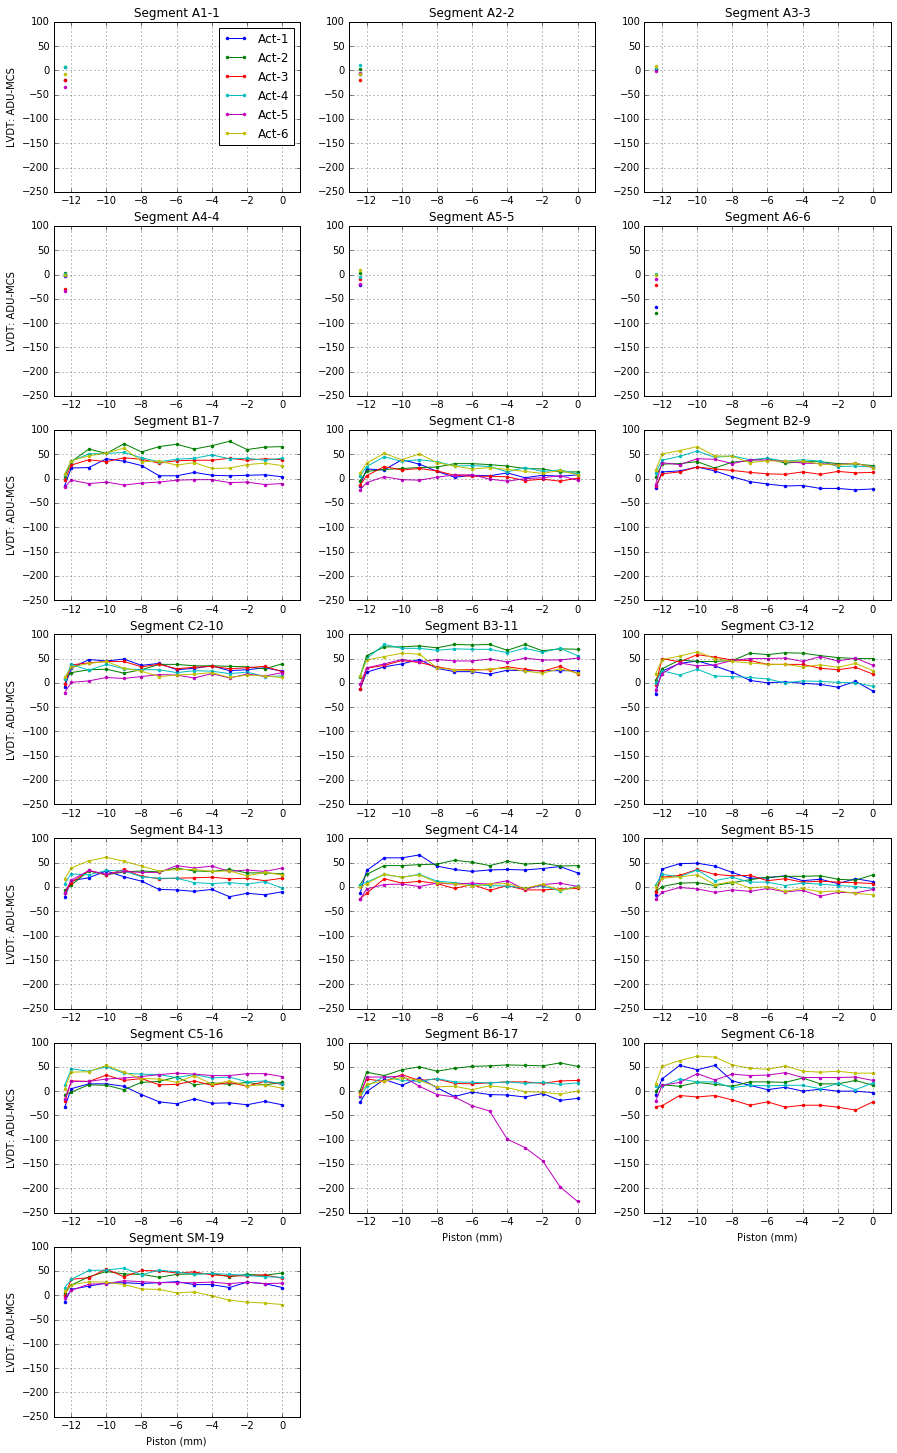

In [9]:
plt.figure(figsize=(15,25))

nrows=7
ncols=3

# ONE RECORD PER SEGMENT AND ACTUATOR:
for irec in newrecords:
    iseg = irec[0][0]
    iact = irec[0][1]
    plt.subplot(nrows, ncols, iseg)

    #SPLIT BY PISTON VALUES AND KEEP THE LAST ONE:
    temp = []
    for key, items in groupby(irec, itemgetter(8)):
        for subitem in items:
            pass
        temp.append(subitem)


    LVDT_END_MCS = np.zeros( narch )
    LVDT_END_ADU = np.zeros( narch )
    PISTON       = np.zeros( narch )
    PISTON[:]    = np.nan #DO THIS TO AVOID PLOTTING "EMPTY" POINTS
    
    for ientry in xrange(narch):
        try:
            LVDT_END_ADU[ientry] = temp[ientry][2]
            LVDT_END_MCS[ientry] = temp[ientry][3]
            PISTON[ientry]       = temp[ientry][8]
        except: pass
    
    plt.plot(PISTON*1000., LVDT_END_ADU-LVDT_END_MCS,'.-', label='Act-{:d}'.format(iact))
    plt.xlim(-13., 1.)
    plt.ylim(-250., 100.)
    plt.grid(True)
    
    if iseg >= 17: plt.xlabel("Piston (mm)")
    if iseg ==1: plt.legend()
    if (iseg-1)%ncols== 0: plt.ylabel("LVDT: ADU-MCS")
    plt.title("Segment {:s}".format(segmentnames[iseg-1]))
    
plt.savefig("LVDT_ADU-MCS.pdf")

# 2. PLOT LVDT DIFFERENCES (ALL RECORDS)

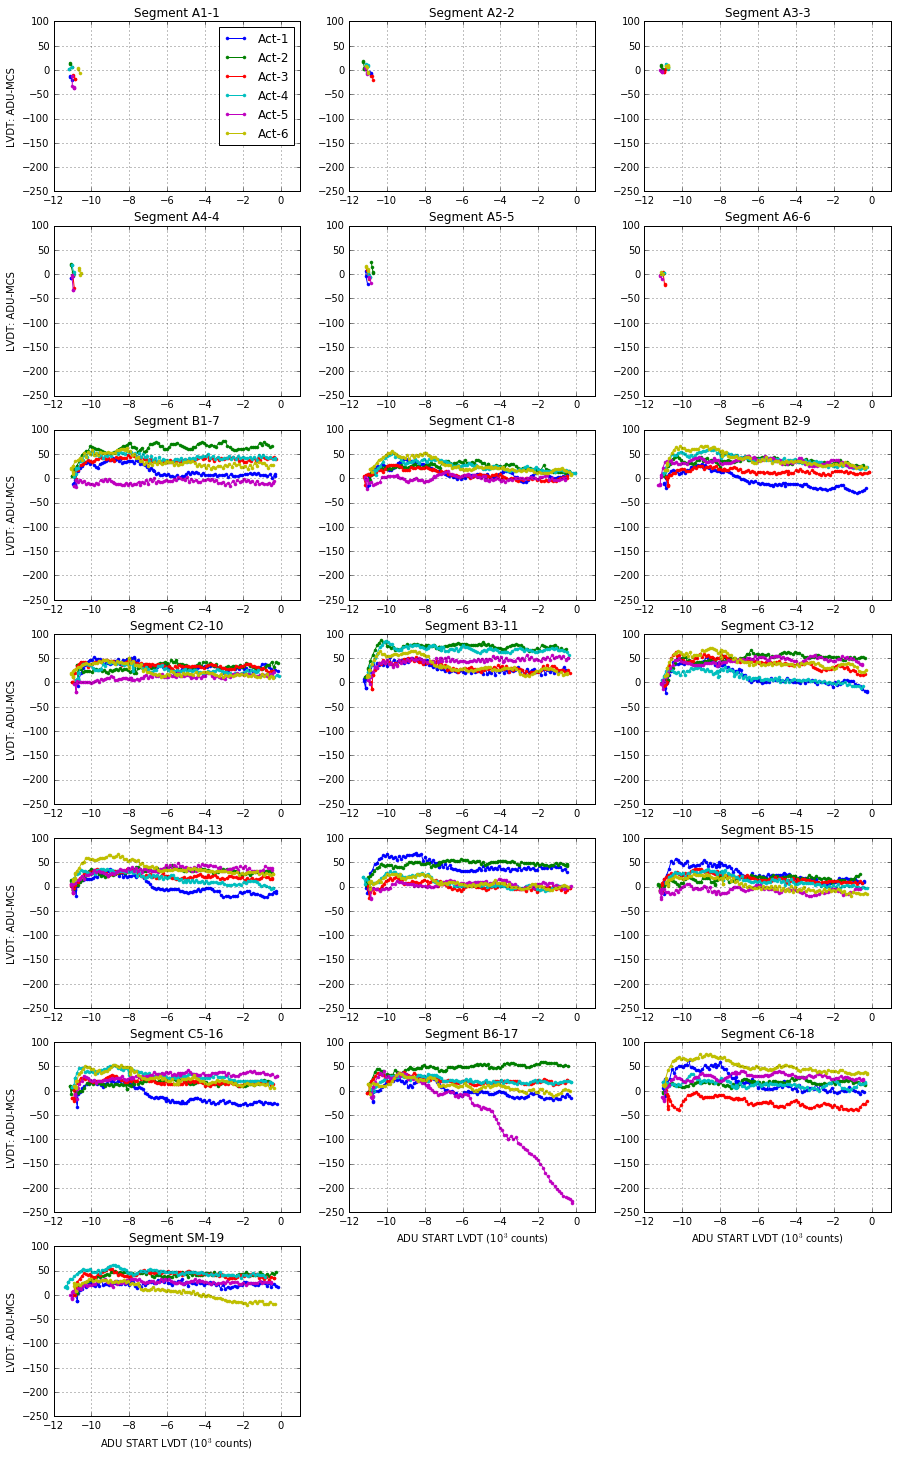

In [10]:
plt.figure(figsize=(15,25))

nrows=7
ncols=3

nmax = len(max(newrecords,key=len))

for irec in newrecords:
    iseg = irec[0][0]
    iact = irec[0][1]
    plt.subplot(nrows, ncols, iseg)
        

    LVDT_DIFF    = np.zeros( nmax )
    LVDT_DIFF[:] = np.nan
    LVDT_START_ADU       = np.zeros( nmax )
    LVDT_START_ADU[:]    = np.nan #DO THIS TO AVOID PLOTTING "EMPTY" POINTS
    
    for ientry in xrange(nmax):
        try:
            LVDT_DIFF[ientry]      = irec[ientry][2] - irec[ientry][3]
            LVDT_START_ADU[ientry] = irec[ientry][2]
        except: pass
                
    plt.plot(LVDT_START_ADU/1000., LVDT_DIFF,'.-', label='Act-{:d}'.format(iact))
    plt.xlim(-12., 1.)
    plt.ylim(-250., 100.)
    plt.grid(True)
        
    if iseg >= 17: plt.xlabel("ADU START LVDT (10$^3$ counts)")
    if iseg ==1: plt.legend()
    if (iseg-1)%ncols== 0: plt.ylabel("LVDT: ADU-MCS")
    plt.title("Segment {:s}".format(segmentnames[iseg-1]))

    LVDT_START_ADU[:] = np.nan

# plt.savefig("LVDT_BIPODS.pdf")

# USING PANDAS DATA FRAMES (LVDT DIFFERENCES):

In [11]:
import pandas as pd

csvfile="/Users/lajoie/MCS_Testing/LVDT_table.csv"
df = pd.read_csv(csvfile)

df.sort_values(by=["SEG_ID",'ACT_ID','CID','CMD_NUM'], inplace=True)

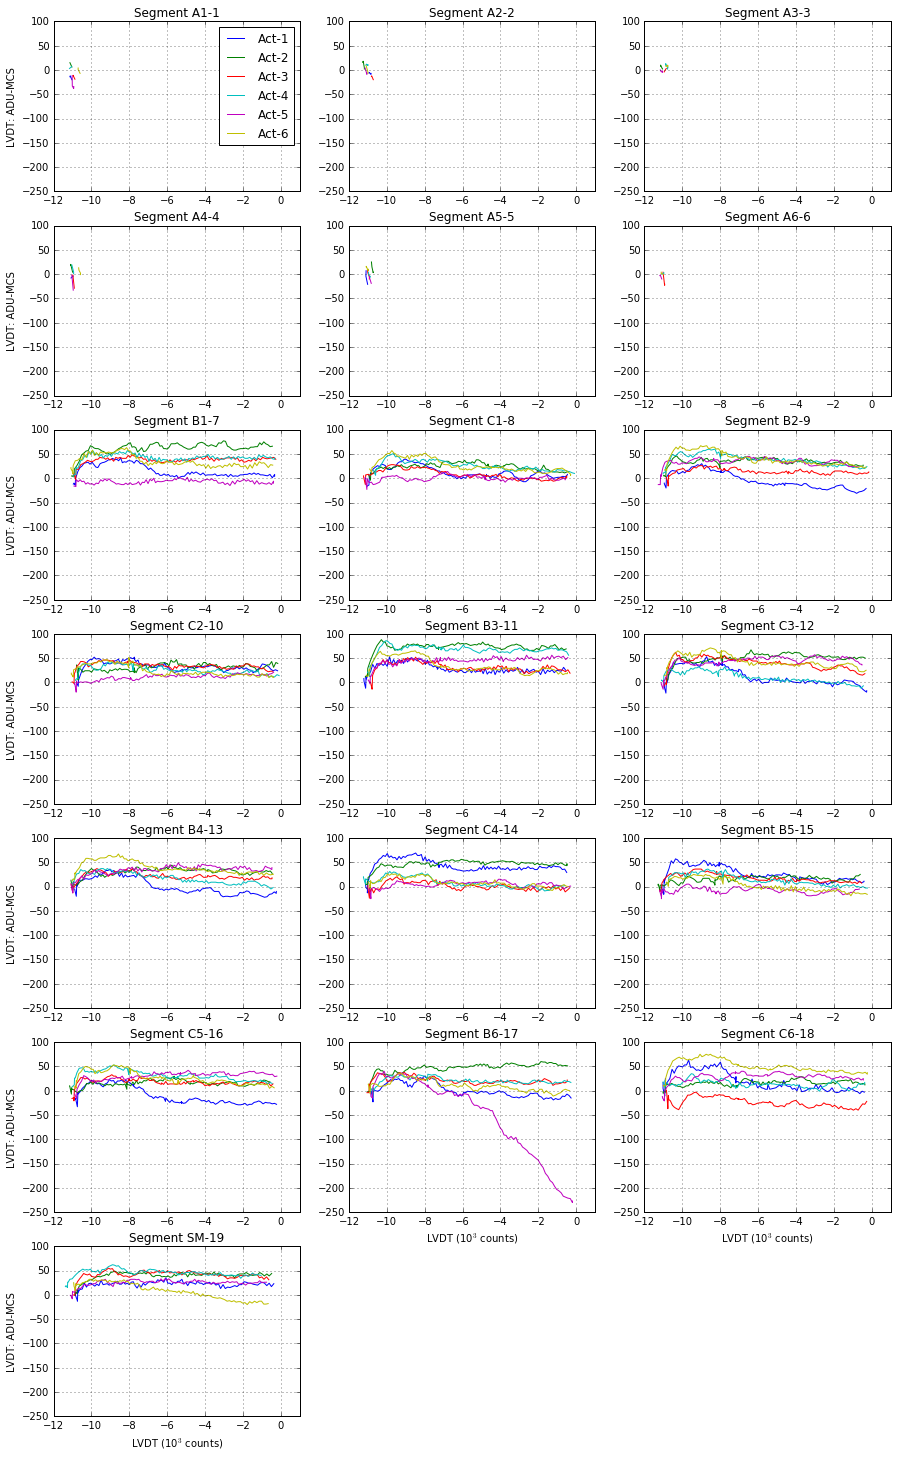

In [12]:
segmentnames = ["A1-1", "A2-2", "A3-3", "A4-4", "A5-5", "A6-6",
                "B1-7", "C1-8", "B2-9", "C2-10","B3-11", "C3-12", 
                "B4-13", "C4-14", "B5-15","C5-16", "B6-17", "C6-18", "SM-19"]

# GROUP BY SEGMENT AND ACTUATOR:
grouped = df.groupby(by=["SEG_ID","ACT_ID"])


plt.figure(figsize=(15,25))
nrows=7
ncols=3

    
for key, group in grouped:
        iseg = group.SEG_ID.unique()[0]
        iact = group.ACT_ID.unique()[0]
        plt.subplot(nrows, ncols, iseg)
        
        diff = group["START_LVDT_ADU"]-group["START_LVDT_MCS"]
        lvdt = group["START_LVDT_ADU"]
        plt.plot(lvdt/1000., diff,'-', label='Act-{:d}'.format(iact))

        plt.xlim(-12., 1.)
        plt.ylim(-250., 100.)
        plt.grid(True)
        
        if iseg >= 17: plt.xlabel("LVDT (10$^3$ counts)")
        if iseg ==1: plt.legend()
        if (iseg-1)%ncols== 0: plt.ylabel("LVDT: ADU-MCS")
        plt.title("Segment {:s}".format(segmentnames[iseg-1])) 
        
plt.savefig("LVDT_ADU-MCS_ALL.pdf")

# USING PANDAS DATA FRAMES (BIPOD DIFFERENCES):

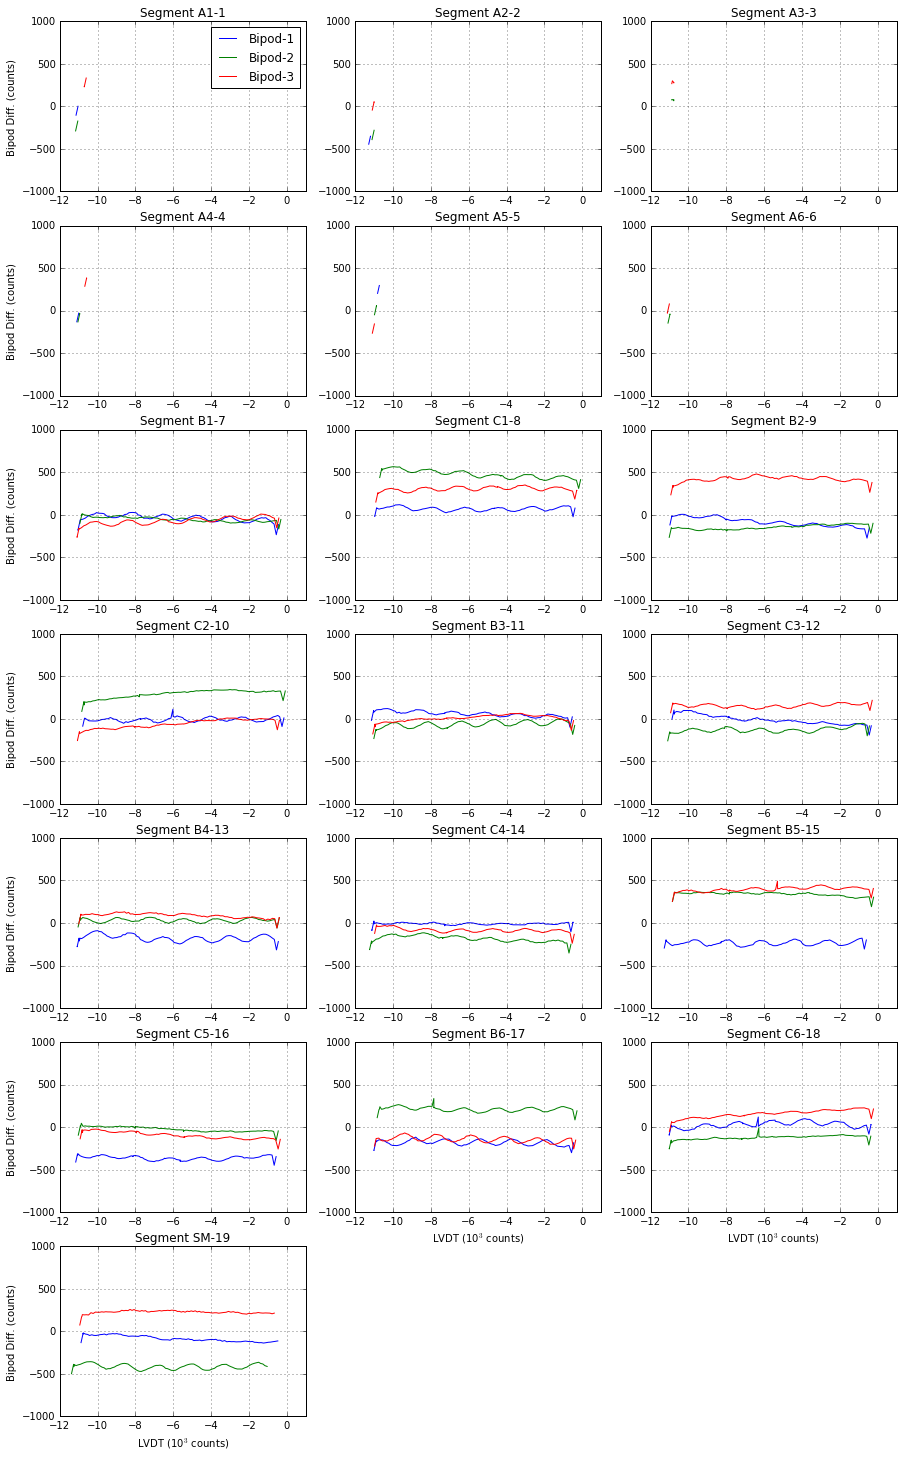

In [13]:
# GROUP BY SEGMENT ONLY THIS TIME:
grouped = df.groupby(by=["SEG_ID","ACT_ID"])

plt.figure(figsize=(15,25))
nrows=7
ncols=3

# LOOP THROUGH SEGMENT AND ACTUATOR, EACH ONE AT A TIME:
for key, group in grouped:  
    iseg = group.SEG_ID.unique()[0]
    iact = group.ACT_ID.unique()[0]
        
        
    if iact==2 or iact==4 or iact==6:
        plt.subplot(nrows, ncols, iseg)
        
        BIPOD = group["BIPOD_DIFF"]
        lvdt  = group["START_LVDT_ADU"]
            
        plt.plot(lvdt/1000., BIPOD,'-', label='Bipod-{:d}'.format(iact/2))

        plt.xlim(-12., 1.)
        plt.ylim(-1000., 1000.)
        plt.grid(True)
        
        if iseg >= 17: plt.xlabel("LVDT (10$^3$ counts)")
        if iseg ==1: plt.legend()
        if (iseg-1)%ncols== 0: plt.ylabel("Bipod Diff. (counts)")
        plt.title("Segment {:s}".format(segmentnames[iseg-1])) 

        
plt.savefig("LVDT_BIPODS.pdf")